# IAU Projekt 3. fáza

### Autori: Martin Raffáč (50%), Tibor Vanek (50%)

dataset číslo **003**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, metrics
from pandas import read_csv
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot
import os
#import graphviz 
#import pydot
from IPython.display import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.feature_selection import VarianceThreshold

In [2]:
train_data = pd.read_csv("num_data.csv", sep=',')
test_data = pd.read_csv("test_data.csv", sep=',')

Náčítanie trénovacích dát.

In [3]:
data_for_oneR = train_data.copy()

## 1. Jednoduchý klasifikátor na základe závislosti v dátach 

In [4]:
def oneR(column):

    split = (data_for_oneR[column][data_for_oneR['warning'] == 0].mean() + data_for_oneR[column][data_for_oneR['warning'] == 1].mean())/2
    group = data_for_oneR[data_for_oneR[column] > split]
    group = group.groupby('warning').size()

    if group[0] > group[1]:
        left = 1
        right = 0
    else:
        left = 0
        right = 1
        
    predict = {"split": split, "left": left, "right": right}
    
    data_for_oneR.loc[data_for_oneR[column] < predict["split"], 'helper'] = predict["left"]
    data_for_oneR.loc[data_for_oneR[column] >= predict["split"], 'helper'] = predict["right"]
    accuracy = accuracy_score(data_for_oneR['warning'], data_for_oneR['helper'])
    precision = precision_score(data_for_oneR['warning'], data_for_oneR['helper'])
    recall = recall_score(data_for_oneR['warning'], data_for_oneR['helper'])
    total=(accuracy + precision + recall) / 3
    data_for_oneR.drop('helper', axis=1, inplace=True)

    return {"accuracy": accuracy, "precision": precision, "recall": recall ,"total": total}

In [5]:
accuracy = 0 
columns =  data_for_oneR.columns

for i in columns:
    if i == 'warning':
        continue

    data_oneR = oneR(i)
    
    if data_oneR["total"] > accuracy:
        best = i
        accuracy = data_oneR["total"]
        best_column = data_oneR
        
print('best oneR: ' + best)
print('total_score: ' + str(best_column["total"]))
print('accuracy_score: ' + str(best_column["accuracy"]))
print('precision_score: ' + str(best_column["precision"]))
print('recall_score: ' + str(best_column["recall"]))

best oneR: PAHs
total_score: 0.8234555012157715
accuracy_score: 0.8037125988191735
precision_score: 0.857682841068917
recall_score: 0.8089710637592239


Podľa zadania sme zhotovili jednoduchý algoritmus oneR, ktorý sme vložili do funkcie. Následne sme ho vyskúšali na trénovacom datasete, predpokladali sme, že najlepší výsledok dosiahne atrihút PAHs, pretože má najviššiu koreláciu s atribútom warning. Ako je možné vidieť vyššie naše predpoklady sa naplinili.  

## 2. Trénovanie a vyhodnotenie klasifikátorov strojového učenia

In [6]:
# treba trochu precistit dataset
train_data.drop(["Unnamed: 0"], axis= "columns", inplace = True)
test_data.drop(["Unnamed: 0", "station", "QoS", "code", "revision"], axis= "columns", inplace = True)

### <font color = "red"> ^ neviem ci to mozeme dropnut ale so stringami nefungoval decision tree classifier </font>

In [7]:
train_data.head()

,longitude,C2H3NO5,O3,CO,warning,Pb,PAHs,PM2.5,PRES,TEMP,latitude,NH3,H2CO,SO2,CH4,PM10,CFCs,NOx
0,24.71204,1.070252,-1.238620,1.959980,0.0,1.721996,-0.092043,0.448304,1122.65351,1.764982,41.57439,1.117308,0.869652,-1.940827,-0.598728,0.095732,-0.830261,-0.721449
1,4.82313,0.578681,0.485670,-2.092726,1.0,-0.575596,0.119173,-0.232674,1179.09201,-1.085262,51.24197,0.693448,0.943992,2.040075,-0.444039,0.680288,-0.288815,-0.057048
2,-56.52361,0.371154,-0.056290,0.060240,1.0,1.651889,1.379517,-1.280428,1126.88498,-0.269432,-33.38056,0.465891,-0.539478,1.243666,-0.548210,0.408908,1.053929,1.299415
3,37.38115,-0.003663,0.977303,0.946749,1.0,0.261248,-0.404670,-0.900826,1117.28353,-0.918316,55.63711,0.762944,-0.369243,0.435193,0.381526,0.133697,0.860512,-0.587729
4,43.23790,1.455815,1.644195,1.158715,0.0,-0.471272,-1.816661,-0.465624,1106.68396,0.290596,50.06000,0.690615,0.885281,-0.446552,0.452009,1.535017,-0.535383,0.501325


In [8]:
test_data.head()

,longitude,C2H3NO5,O3,CO,warning,Pb,PAHs,PM2.5,PRES,TEMP,latitude,NH3,H2CO,SO2,CH4,PM10,CFCs,NOx
0,-76.72803,0.034080,8.86027,8.866800,1.0,49.91558,8.64479,8.35431,1137.925500,2.09734,39.32288,10.38681,25.77306,10.40514,8.69823,6.936440,44.98104,6.90200
1,74.83554,0.162671,9.19179,7.196330,0.0,54.01509,5.45514,9.36486,1115.100240,16.16098,14.62072,7.33226,30.70238,7.78304,6.66323,7.428166,49.29094,7.09370
2,-3.05814,0.154050,9.29043,7.056980,0.0,50.56311,7.25193,9.46052,1120.887250,6.09876,53.00974,6.10828,51.19238,7.26165,6.41923,9.143780,55.31251,6.49570
3,10.03988,0.030910,8.71918,8.669590,0.0,58.40231,6.54822,8.37049,1129.741470,18.32487,53.60520,6.59860,40.41077,10.87272,6.33447,6.847320,32.52839,9.36406
4,-116.56346,0.038010,5.88474,8.222016,1.0,54.93329,8.43879,7.85637,1124.957487,30.11868,43.54072,9.20000,46.81541,9.78392,10.07961,7.327750,46.76573,6.01282


Stĺpec warning si oddelíme od datasetu do samostatných premenných

In [9]:
train_target = train_data["warning"]
test_target = test_data["warning"]

use_train_data = train_data.drop(["warning"], axis = "columns")
use_test_data = test_data.drop(["warning"], axis = "columns")

In [10]:
dtf = tree.DecisionTreeClassifier()
dtf.fit(use_train_data, train_target)
prediction = dtf.predict(use_test_data)
print("Score: ", dtf.score(use_test_data, test_target))

Score:  0.40724434660796477


^ neviem preco je to tak low

In [11]:
print(classification_report(test_target, prediction, target_names = ["0","1"]))

              precision    recall  f1-score   support

           0       0.41      1.00      0.58      2036
           1       0.00      0.00      0.00      2961

    accuracy                           0.41      4997
   macro avg       0.20      0.50      0.29      4997
weighted avg       0.17      0.41      0.24      4997



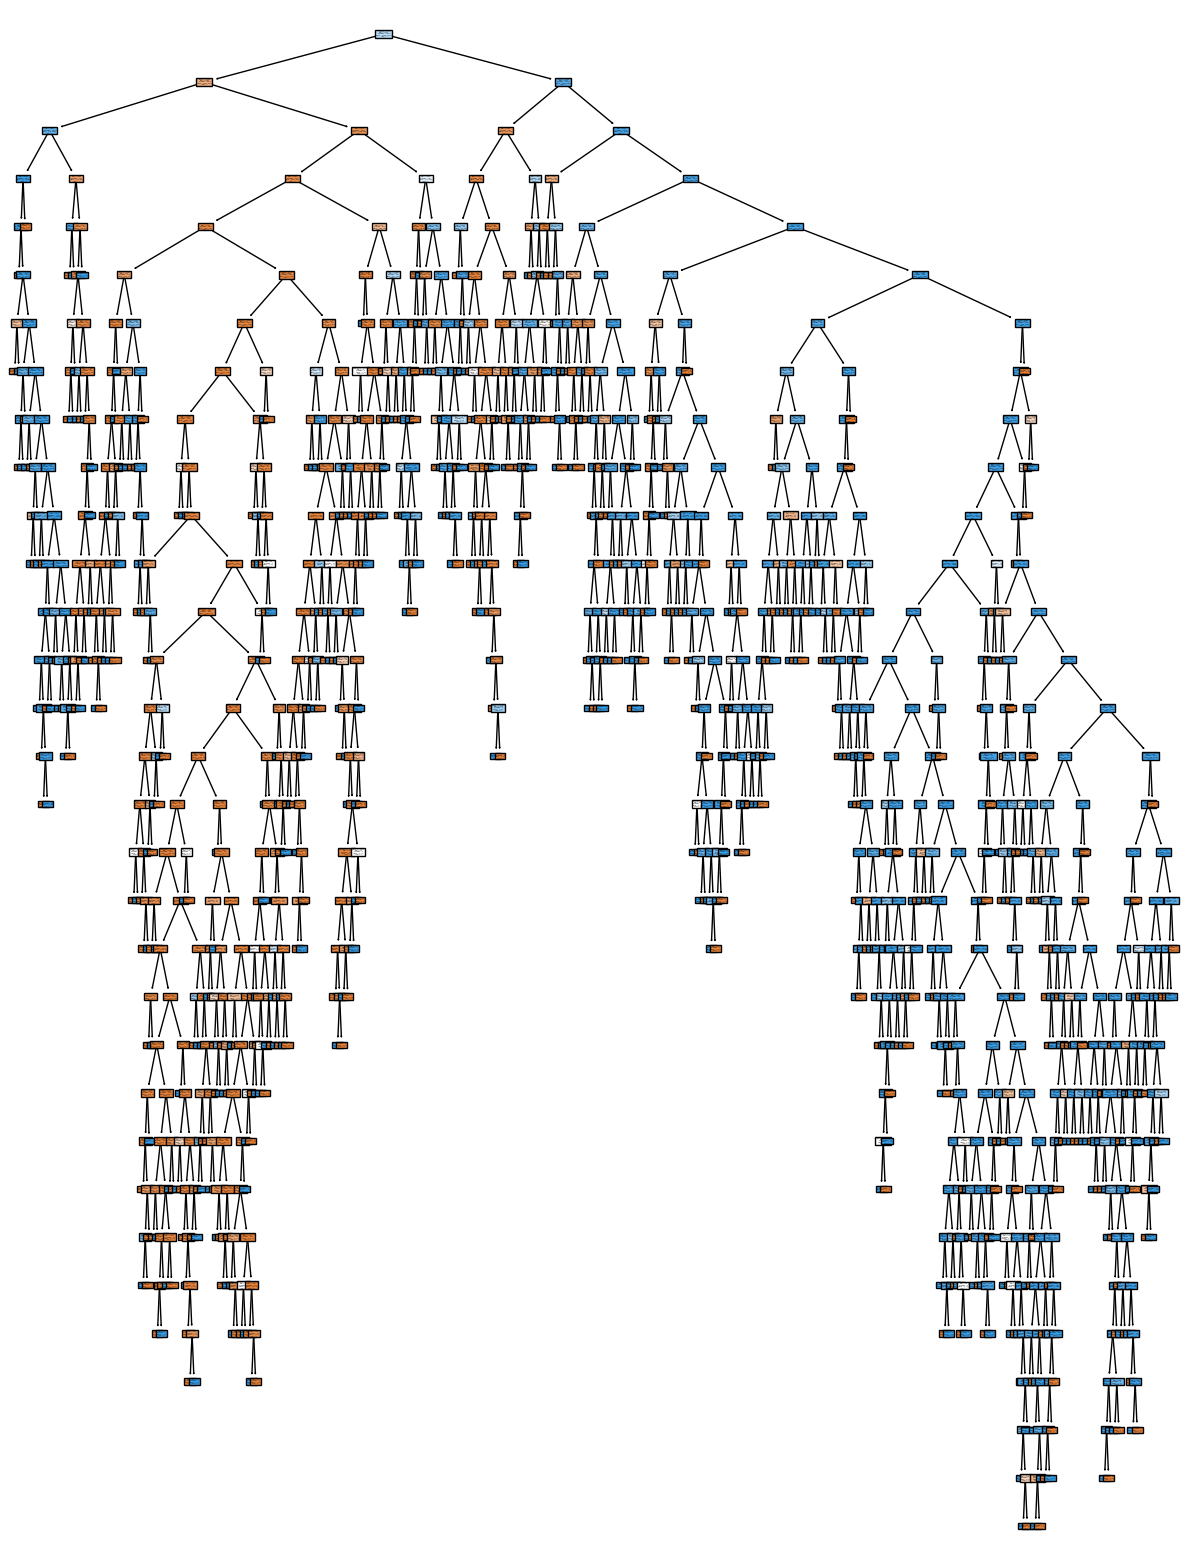

In [28]:
# graphviz nefungoval, toto je prilis velky obrazok
#fig = plt.figure(figsize = (15, 20))
#_ = tree.plot_tree(dtf, feature_names = use_test_data.columns, class_names = ["1","0"], filled = True)
#fig.savefig("strom.png")